# Mental Health Chatbot

## Goal


## RAG

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import sys
print(sys.executable)
import wandb
import gradio as gr
import psycopg2
from dotenv import load_dotenv
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from rank_bm25 import BM25Okapi
from openai import OpenAI
load_dotenv()
NEON_PG_CONNECTION_URL = os.environ['NEON_PG_CONNECTION_URL']

### Data Pre-Processing & Insert to DB

In [ ]:
def preprocess_data():
    ds1 = load_dataset("Amod/mental_health_counseling_conversations")
    ds2 = load_dataset("mpingale/mental-health-chat-dataset")

    # Rename columns "Context": "Question", "Response": "Answer" of ds1
    ds1 = ds1.rename_column("Context", "Question")
    ds1 = ds1.rename_column("Response", "Answer")
    ds2 = ds2.remove_columns(["questionID", "questionTitle", "questionLink", "topic", "therapistInfo", "therapistURL", "upvotes", "views", "text"])
    ds2 = ds2.rename_column("questionText", "Question")
    ds2 = ds2.rename_column("answerText", "Answer")

    # Convert to pandas DataFrame
    df1 = ds1['train'].to_pandas()
    df2 = ds2['train'].to_pandas()

    # Drop duplicates & NAs
    df1 = df1.drop_duplicates(subset=["Question", "Answer"]).dropna(subset=["Question", "Answer"])
    df2 = df2.drop_duplicates(subset=["Question", "Answer"]).dropna(subset=["Question", "Answer"])

    # Combine datasets
    combined_df = pd.concat([df1, df2])

    questions = combined_df['Question'].tolist()
    answers = combined_df['Answer'].tolist()

    return questions, answers

# Connect to the database
try:
    connection = psycopg2.connect(NEON_PG_CONNECTION_URL)
    connection.autocommit = True
    print("Connected to Neon Postgres!")
except Exception as e:
    print("Cannot connect to Neon Postgres:", e)

cursor = connection.cursor()

questions, answers = preprocess_data()
# Vectorization
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
question_vectors = model.encode(questions)
cursor.execute("""
    CREATE TABLE IF NOT EXISTS mental_health_qa (
        id SERIAL PRIMARY KEY,
        question TEXT,
        answer TEXT,
        vector FLOAT8[]
    )
""")

# Insert the data into the database
for i in range(len(questions)):
    cursor.execute("""
        INSERT INTO mental_health_qa (question, answer, vector)
        VALUES (%s, %s, %s)
    """, (questions[i], answers[i], question_vectors[i].tolist()))
connection.close()

### Retrieval Model

In [ ]:
# Function to query the database and augment responses
def query_and_augment(user_query):
    # Connect to the database
    connection = psycopg2.connect(NEON_PG_CONNECTION_URL)
    cursor = connection.cursor()

    cursor.execute("SELECT question, answer FROM mental_health_qa")
    records = cursor.fetchall()

    questions = [record[0] for record in records]
    answers = [record[1] for record in records]

    # Close the connection
    connection.close()
    
    # Implement BM25 to find the best match
    tokenized_questions = [q.split() for q in questions]
    bm25 = BM25Okapi(tokenized_questions)
    best_match_index = bm25.get_top_n(user_query.split(), questions, n=1)[0]
    # print the top 5 matches
    print(bm25.get_top_n(user_query.split(), questions, n=5))
    best_answer = answers[questions.index(best_match_index)]

    # Generate augmented answer using the pipeline
    # prompt = f"User: {user_query}\n\n\nLimit your knowledge to these related questions only:\n\nBot: {best_answer}\nBot (improved):"
    prompt = f"User: {user_query}\n\n\nImprove the response from the database:\n\nBot: {best_answer}\nBot (improved):"
    print(f"Prompt: {prompt}")
    client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])
    response = client.chat.completions.create(
        messages=[
            {"role": "user", "content": "Answer the user_query based on the best answer.\n\n" + prompt},
            {"role": "assistant", "content": best_answer}
        ],
        model="gpt-4o",
        temperature=0.1,
    )
    return response.choices[0].message.content

# answer = query_and_augment("My grandson's step-mother sends him to school with a pink Barbie backpack as a form of punishment.")
answer = query_and_augment("I'm feeling depressed")
print(answer)
# Define Gradio Interface
# def chatbot_interface(user_query):
#     return query_and_augment(user_query)

# interface = gr.Interface(fn=chatbot_interface, inputs="text", outputs="text", title="Mental Health Chatbot")
# interface.launch()

# Fine-tuning Approach - without Emotion

In [21]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, load_metric
import json
import matplotlib.pyplot as plt
import gradio as gr

### Data Preparation & Model Setup

In [15]:
# Load Dataset
dataset = load_dataset('Estwld/empathetic_dialogues_llm')
dataset = dataset['train'].select(range(10000))

# Explore the data
def explore_data(dataset, tokenizer):
    num_conversations = len(dataset)
    max_length = 0
    longest_conversation = None

    for example in dataset:
        conversations = example['conversations']
        inputs = [turn['content'] for turn in conversations]
        tokenized_inputs = tokenizer(inputs, padding=False, truncation=False)
        total_length = sum(len(tokens) for tokens in tokenized_inputs['input_ids'])
        if total_length > max_length:
            max_length = total_length
            longest_conversation = conversations

    print(f"Number of conversations: {num_conversations}")
    print(f"Length of the longest conversation: {max_length} tokens")
    print("Longest conversation:", json.dumps(longest_conversation, indent=4))

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('openai-community/gpt2')
tokenizer.add_special_tokens({'additional_special_tokens': ['<USER>', '<ASSISTANT>', '<PAD>']})
tokenizer.pad_token = '<PAD>'

# Explore data with token length
explore_data(dataset, tokenizer)

# Preprocess Data
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2')
model.resize_token_embeddings(len(tokenizer))

# Tokenize. Identify the role of the speaker. Append the role and the emotion to the beginning
# of each conversation.
def preprocess_function(examples):
    inputs = []
    labels = []
    for i in range(len(examples['conversations'])):
        conversations = examples['conversations'][i]
        emotion = examples['emotion'][i]
        for turn in conversations:
            role = '<USER>' if turn['role'] == 'user' else '<ASSISTANT>'
            input_text = f"<{emotion.upper()}> {role} {turn['content']}"
            inputs.append(input_text)
            labels.append(input_text)  # Use the same text as labels for language modeling
    tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=512)
    tokenized_inputs['labels'] = tokenized_inputs['input_ids'].copy()  # Set labels
    return tokenized_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset.column_names)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(tokenized_datasets))
val_size = len(tokenized_datasets) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(tokenized_datasets, [train_size, val_size])

# Fine-Tune GPT-2
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    learning_rate=5e-5,
    report_to='wandb',
    run_name='gpt2-finetuning'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Number of conversations: 10000
Length of the longest conversation: 472 tokens
Longest conversation: [
    {
        "content": "Life can be really not a happy place.",
        "role": "user"
    },
    {
        "content": "Sadly, I agree with you.  As I get older, it seems like that more and more.  What happened that made you feel that way?",
        "role": "assistant"
    },
    {
        "content": "Oh so many things. Lots of trauma. Life really is just full of lots of really difficult events..trying to maintain your spirit and being a good person through it, is really the task of life!",
        "role": "user"
    },
    {
        "content": "Its so true! I battle chronic illness and excruciating pain daily for almost 14 years now not to mention drowning in old medical bills.  I put my faith in God and pray for relief.  Its really hard to stay optimistic.  I really hope life improves for you and you can enjoy and embrace life again.  ",
        "role": "assistant"
    },
    {
   

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [30]:
from transformers import GPT2Tokenizer

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Text to count tokens for
text = "THANK YOU! That sounds GREAT! yes the raw groups on FB have good diets too! I need to do vegan as well! Just can't afford it yet. Doing Fasting with Keto WOW- That is true! I just feel tapped out after so much abuse and trauma..and losing pets and children..Just too much trauma in a short time, but I am still here! I am trying to get better, it's just a long hard journey. LOVE to you! Stay strong and kind like you are! So inspiring!"

# Count the number of tokens
num_tokens = len(tokenizer.encode(text))
print(num_tokens)

110


### Training & Evaluation

In [17]:
# Evaluate Model
trainer.train()

# Save and Deploy Model
model.save_pretrained('./fine_tuned_gpt2')
tokenizer.save_pretrained('./fine_tuned_gpt2')

  0%|          | 0/4288 [00:00<?, ?it/s]

{'loss': 0.1204, 'grad_norm': 0.20129862427711487, 'learning_rate': 4.416977611940299e-05, 'epoch': 0.12}
{'loss': 0.1245, 'grad_norm': 0.18215014040470123, 'learning_rate': 3.833955223880597e-05, 'epoch': 0.23}
{'loss': 0.1212, 'grad_norm': 0.13758499920368195, 'learning_rate': 3.250932835820896e-05, 'epoch': 0.35}
{'loss': 0.1191, 'grad_norm': 0.1824861615896225, 'learning_rate': 2.6679104477611942e-05, 'epoch': 0.47}
{'loss': 0.1186, 'grad_norm': 0.13692069053649902, 'learning_rate': 2.084888059701493e-05, 'epoch': 0.58}
{'loss': 0.1177, 'grad_norm': 0.1363353580236435, 'learning_rate': 1.501865671641791e-05, 'epoch': 0.7}
{'loss': 0.1159, 'grad_norm': 0.12549316883087158, 'learning_rate': 9.188432835820895e-06, 'epoch': 0.82}
{'loss': 0.1172, 'grad_norm': 0.1320410966873169, 'learning_rate': 3.358208955223881e-06, 'epoch': 0.93}


  0%|          | 0/1072 [00:00<?, ?it/s]

{'eval_loss': 0.11245960742235184, 'eval_runtime': 229.7416, 'eval_samples_per_second': 37.329, 'eval_steps_per_second': 4.666, 'epoch': 1.0}
{'train_runtime': 3095.1183, 'train_samples_per_second': 11.082, 'train_steps_per_second': 1.385, 'train_loss': 0.11912327737950568, 'epoch': 1.0}


  0%|          | 0/1072 [00:00<?, ?it/s]

NameError: name 'plt' is not defined

  0%|          | 0/1072 [00:00<?, ?it/s]

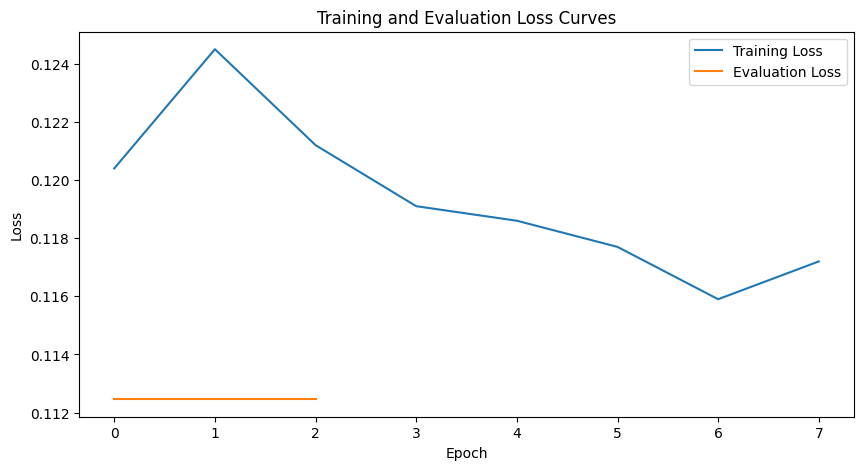

In [19]:
trainer.evaluate()
# Extract training and evaluation metrics
train_loss = trainer.state.log_history
eval_loss = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]
train_loss = [entry['loss'] for entry in train_loss if 'loss' in entry]

# Plot the training and evaluation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.show()

### Generate Responses

In [28]:

# Load the base GPT-2 model and tokenizer
base_model_name = 'gpt2'
base_tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
base_model = GPT2LMHeadModel.from_pretrained(base_model_name)

# Load the fine-tuned GPT-2 model and tokenizer
fine_tuned_model_path = './fine_tuned_gpt2'
fine_tuned_tokenizer = GPT2Tokenizer.from_pretrained(fine_tuned_model_path)
fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_path)

def generate_response(model_name, user_query):
    if model_name == 'Base GPT-2':
        tokenizer = base_tokenizer
        model = base_model
    else:
        tokenizer = fine_tuned_tokenizer
        model = fine_tuned_model

    # Define the prompt to set the context
    prompt = f"User: {user_query}\nAssistant:"

    # Tokenize the input
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask

    # Generate response
    outputs = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=150,  # Set a reasonable max length
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        num_beams=5,  # Use beam search with 5 beams
        temperature=0.7,  # Control randomness
        top_p=0.9  # Control diversity
    )
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Optionally, truncate the response at the first stop token (e.g., newline)
    stop_token = '\n'
    if stop_token in response:
        response = response.split(stop_token)[0]
    
    return response

# Create Gradio interface
iface = gr.Interface(
    fn=generate_response,
    inputs=[
        gr.components.Dropdown(choices=['Base GPT-2', 'Fine-Tuned GPT-2'], label='Model'),
        gr.components.Textbox(lines=5, placeholder='Enter your query here...', label='User Query')
    ],
    outputs='text',
    title='Chat with GPT-2',
    description='Select a model and enter your query to chat with GPT-2 or the fine-tuned GPT-2 model.'
)

# Launch the interface
iface.launch()

/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/Users/hubert_1/.local/share/virtualenvs/mental_health_chatbot-vOkgE1F_/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


## Prompt Engineering

### Imports